# Lab Deep Learning/ Recurrent Neural Networks/ in keras

## Using Many-to-One for movie rating predicton

**Supervisor: geoffroy.peeters@telecom-paris.fr**

**Author: Ossee Yiboe**
    
For any remark or suggestion, please feel free to contact me.

## Objective:
We will implement two different networks to perform automatic rating (0 or 1) of a movie given the text of its review.
We will use the ```imdb``` (internet movie database) dataset.

The reviews are already available in the form of indexes that point to a word dictionary: each word is already encoded as an index in the dictionary.

## Import packages

In [ ]:
import numpy as np
from tensorflow.keras.datasets import imdb
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dense, Activation, Embedding, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector

colab = True
student = True

## Parameters of the model

-  We only consider the ```top_words``` first words in the word dictionary
- We truncate/zero-pad each sequence a length ```max_review_length```

In [ ]:
top_words = 5000
max_review_length = 100
INDEX_FROM = 3
embedding_vector_length = 32

## Import IMDB data

In [ ]:
# --- Import the IMDB data and only consider the ``top_words``` most used words
np.load.__defaults__=(None, True, True, 'ASCII')
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words, index_from=INDEX_FROM)
np.load.__defaults__=(None, False, True, 'ASCII')

17464789/17464789 [==============================] - 2s 0us/step


## Data content

- ```X_train``` and ```X_test``` are numpy arrays of lists. 
  - each item in a list is the index in the word dictionary. So that a list is the sequence of index of words.

- ```y_train``` and ```y_test``` are a numpy arrays of the same dimension as ```X_train``` and ```X_test``` 
  - they contains the values 0 (bad movie) or 1 (good movie)

type(X_train): <class 'numpy.ndarray'>
number of training sequences: X_train.shape: (25000,)
type(X_train[0]): <class 'list'>
length of the first training sequence: len(X_train[0]): 218
length of the second training sequence: len(X_train[1]): 189
list of data of the first training sequence: X_train[0]: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 

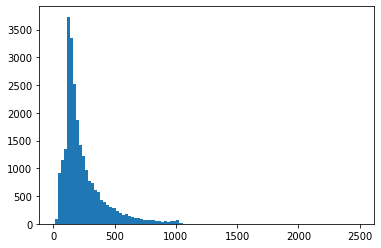

In [ ]:
print("type(X_train):", type(X_train))
print("number of training sequences: X_train.shape:", X_train.shape)
print("type(X_train[0]):",type(X_train[0]))
print("length of the first training sequence: len(X_train[0]):",len(X_train[0]))
print("length of the second training sequence: len(X_train[1]):",len(X_train[1]))
print("list of data of the first training sequence: X_train[0]:", X_train[0] )
len_list = [len(train) for train in X_train]
print("maximum length of a training sequence:", max(len_list))

import matplotlib.pyplot as plt
plt.hist(len_list, 100);

## Details of how the reviews are encoded

In [ ]:
word_to_id = imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

id_to_word = {value:key for key,value in word_to_id.items()}
print(' '.join(id_to_word[id] for id in X_train[1000] ))

<START> although i had seen <UNK> in a theater way back in <UNK> i couldn't remember anything of the plot except for vague images of kurt thomas running and fighting against a backdrop of stone walls and disappointment regarding the ending br br after reading some of the other reviews i picked up a copy of the newly released dvd to once again enter the world of <UNK> br br it turns out this is one of those films produced during the <UNK> that would go directly to video today the film stars <UNK> <UNK> kurt thomas as jonathan <UNK> <UNK> out of the blue to <UNK> the nation of <UNK> to enter and hopefully win the game a <UNK> <UNK> <UNK> by the khan who <UNK> his people by yelling what sounds like <UNK> power the goal of the mission involves the star wars defense system jonathan is trained in the martial arts by princess <UNK> who never speaks or leaves the house once trained tries to blend in with the <UNK> by wearing a bright red <UNK> with <UNK> of blue and white needless to say <UNK>

In [ ]:
print("type(y_train):", type(y_train))
print("y_train.shape:", y_train.shape)

type(y_train): <class 'numpy.ndarray'>
y_train.shape: (25000,)


In [ ]:
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_test.shape: (25000,)
y_test.shape: (25000,)


## Data processing

Sequences (represented as a list of values) in ```X_train``` represent the reviews.
They can have different length.
To train the network we should modify them so that they all have the same length.
We do this by:
- truncating the ones that are too long
- padding-with-zero them the ones that are too short.

This is obtained using ```sequence.pad_sequences``` of keras.

In [ ]:
# --- truncate and pad input sequences

if student:
    X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_review_length)
    X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_review_length)

print("len(X_train[0]):", len(X_train[0]))
print("len(X_train[1]):", len(X_train[1]))
print("X_train[0]:", X_train[0])

len(X_train[0]): 100
len(X_train[1]): 100
X_train[0]: [1415   33    6   22   12  215   28   77   52    5   14  407   16   82
    2    8    4  107  117    2   15  256    4    2    7 3766    5  723
   36   71   43  530  476   26  400  317   46    7    4    2 1029   13
  104   88    4  381   15  297   98   32 2071   56   26  141    6  194
    2   18    4  226   22   21  134  476   26  480    5  144   30    2
   18   51   36   28  224   92   25  104    4  226   65   16   38 1334
   88   12   16  283    5   16 4472  113  103   32   15   16    2   19
  178   32]


In [ ]:
print(X_train.shape)

(25000, 100)


# First model

<img src="https://perso.telecom-paristech.fr/gpeeters/doc/Lab_DL_RNN_01.png">

In the first model, we will simply 
- learn a word embedding  (```Embedding``` layer in keras) and apply it to each item of the sequence, 
  -  in keras, embedding is not a matrix going from one-hot-encoding to embedding, but is a layer that goes from index-in-word-dictionary to embedding
  - the embedding goes from ```top_words``` dimensions to  ```embedding_vector_length``` dimensions
- average the embedding obtained for each word of a sequence over all words of the sequence (you should use ```K.mean``` and ```Lambda``` from the keras backend)
- apply a fully connected (```Dense``` layer in keras) which output activation is a sigmoid (predicting the 0 or 1 rating)

We will code this model 
- First, using the Sequential API of keras (https://keras.io/models/sequential/)
- Secondly, using the Functional API of keras (https://keras.io/getting-started/functional-api-guide/)


In [ ]:
K.clear_session()

In [ ]:
# --- create the model
# CODE-RNN1-2
if student:
    '''# --- Using the Sequential API
    model = Sequential()
    model.add(Embedding(input_dim = top_words, output_dim=embedding_vector_length)) 
    model.add(Lambda(lambda x: K.mean(x, axis=1)))
    model.add(Dense(1, activation='sigmoid'))'''
    
    # --- Using the Functional API
    inputs = Input(shape=(max_review_length,))
    embedding = Embedding(top_words, embedding_vector_length)(inputs)
    mean_embedding = Lambda(lambda x: K.mean(x, axis=1))(embedding)
    output = Dense(1, activation='sigmoid')(mean_embedding)

    model = Model(inputs=inputs, outputs=output)

print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_6 (Embedding)     (None, 100, 32)           160000    
                                                                 
 lambda_6 (Lambda)           (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# --- compile and fit the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
391/391 [==============================] - 17s 41ms/step - loss: 0.6386 - accuracy: 0.7292 - val_loss: 0.5624 - val_accuracy: 0.7803
Epoch 2/10
391/391 [==============================] - 5s 13ms/step - loss: 0.4868 - accuracy: 0.8150 - val_loss: 0.4400 - val_accuracy: 0.8223
Epoch 3/10
391/391 [==============================] - 5s 13ms/step - loss: 0.3940 - accuracy: 0.8460 - val_loss: 0.3850 - val_accuracy: 0.8376
Epoch 4/10
391/391 [==============================] - 4s 9ms/step - loss: 0.3468 - accuracy: 0.8603 - val_loss: 0.3591 - val_accuracy: 0.8439
Epoch 5/10
391/391 [==============================] - 3s 8ms/step - loss: 0.3186 - accuracy: 0.8708 - val_loss: 0.3450 - val_accuracy: 0.8483
Epoch 6/10
391/391 [==============================] - 3s 8ms/step - loss: 0.2988 - accuracy: 0.8775 - val_loss: 0.3389 - val_accuracy: 0.8504
Epoch 7/10
391/391 [==============================] - 3s 8ms/step - loss: 0.2844 - accuracy: 0.8841 - val_loss: 0.3346 - val_accuracy: 0.8544
Ep

## Results

After only 3 epochs, you should obtain an accuracy around 83-84% for the test data.

In [ ]:
# --- Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 85.39%


## Using the trained embedding to find equivalence between words

Since the embedding is part of the models, we can look at the trained embedding matrix $E$ and use it to get the most similar words (according to the trained matrix $E$) in the dictionary.
Use the weights of the ```Embedding``` layer to find the most similar words to ```great```. We will use an Euclidean distance for that.
- Retrieve the weights of the ```Embedding layer```
- Get the position of ```great``` in the dictionary
- Get the word-embedding of ```great```
- Find (using Euclidean distance), the closest embedded-words to ```great```

In [ ]:
if student:
    # Get the embedding layer
    E = model.layers[1]

    # Retrieve the weights of the embedding layer
    weights = E.get_weights()[0]
    #print(weights)

    # Get the position of "great" in the dictionary
    great_pos = word_to_id['great']
    #print(great_pos)

    # Get the word embedding of "great"
    great_embedding = weights[great_pos]
    #print(great_embedding)

    # Compute the Euclidean distances between "great" and all other words
    distances = np.sqrt(np.sum((weights - great_embedding)**2, axis=1))

    # Get the indices of the closest words (excluding "great" itself)
    closest_indices = np.argsort(distances)[1:11]

    # Print the closest words
    for i in closest_indices:
        print(id_to_word[i])


87
[ 0.8441509  -0.8359999  -0.7897231  -0.78720886 -0.8765376  -0.8008453
  0.7334726  -0.8550506  -0.82029736 -0.7850593  -1.0028948  -0.9471172
  0.913563   -0.761482    0.8753838   0.9130392  -0.897665   -0.82136685
  0.8077366   0.7880319   0.7358941   0.7921295   0.85150224 -0.8955387
  0.8267362  -0.77869093  0.9922463  -0.8114494  -0.8944958  -0.8168078
 -0.8296373   0.7764441 ]
outstanding
fantastic
delight
enjoyable
favorites
rare
enjoyed
greatest
gem
touching


# Second model

In the second model, we will replace
- the average over the sequence of the obtained embedding
- by a RNN layer (more precisely an ```LSTM```) in a Many-To-One configuration with $n_a=128$

We will code this model 
- First, using the Sequential API of keras (https://keras.io/models/sequential/)
- Secondly, using the Functional API of keras (https://keras.io/getting-started/functional-api-guide/)



In [ ]:
K.clear_session()

In [ ]:
# --- create the model

if student:
    # --- Using the Sequential API
    
    '''model = Sequential()
    model.add(Embedding(input_dim=top_words, output_dim=embedding_vector_length, input_length=max_review_length))
    model.add(LSTM(units=128))
    model.add(Dense(units=1, activation='sigmoid'))'''
    
    # --- Using the Functional API
    inputs = Input(shape=(max_review_length,))
    embedding = Embedding(input_dim=top_words, output_dim=embedding_vector_length, input_length=max_review_length)(inputs)
    lstm = LSTM(units=128)(embedding)
    outputs = Dense(units=1, activation='sigmoid')(lstm)

    model = Model(inputs=inputs, outputs=outputs)
   
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 100, 32)           160000    
                                                                 
 lstm_1 (LSTM)               (None, 128)               82432     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 242,561
Trainable params: 242,561
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# --- compile and fit the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/3
391/391 [==============================] - 22s 48ms/step - loss: 0.4137 - accuracy: 0.8111 - val_loss: 0.3530 - val_accuracy: 0.8448
Epoch 2/3
391/391 [==============================] - 7s 17ms/step - loss: 0.3095 - accuracy: 0.8711 - val_loss: 0.3595 - val_accuracy: 0.8452
Epoch 3/3
391/391 [==============================] - 5s 14ms/step - loss: 0.2717 - accuracy: 0.8917 - val_loss: 0.3657 - val_accuracy: 0.8414


## Results

After only 3 epochs, you should obtain an accuracy around 84-85% for the test data.

In [ ]:
# --- Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100)) 

Accuracy: 84.14%
